# TCR Clonotypes

In [1]:
import logging, sys
import numpy as np
sys.path.insert(0, "../..")
import scirpy as ir
import scanpy as sc
from glob import glob
import pandas as pd
import tarfile
import anndata
import warnings
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from numba import NumbaPerformanceWarning


## Since we have debugged the code and know that everything works fine, we now supress all kinds of unwanted messages generated
## and only keep the printed or necessary results. This is for the purpose of better readability of the .pdf report generated.

import warnings
warnings.simplefilter('ignore')

logging.disable(sys.maxsize)
## ignore numba performance warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

## suppress "storing XXX as categorical" warnings.
anndata.logging.anndata_logger.setLevel("ERROR")

In [2]:
combined = sc.read('/scratch/annotated_umap.h5ad')
# We only select the cells that have TCR data
combined = combined[combined.obs['has_ir']=='True']

In [3]:
ir.pp.ir_neighbors(combined, receptor_arms="all", dual_ir="primary_only")

100%|██████████| 2178335/2178335 [00:17<00:00, 123819.29it/s]


In [4]:
# running this would add 'clonotype' and 'clonotyp_size' to the dataframe, which is important for clonotype expansion pipeline
# the inplace=True argument is crutial, without this it will return the result instead of storing the result into combined
ir.tl.define_clonotypes(combined, inplace=True)

In [5]:
ir.tl.clonotype_network(combined, min_size=2)

#### Notice, if we choose metric='identity' or any other alignment metrics, all of the following function calls that involves a metric argument need to be uniform with this choice. Otherwise, key error will be raised since the keys are only associated with this specific metric that we choose.

In [6]:
# we use the "identity" metric to only classify clonotypes based on exact match because the motifs are fairly short sequenced
ir.pp.ir_neighbors(combined, metric="identity", sequence="aa",
                   receptor_arms="all", dual_ir="all")

100%|██████████| 2292409/2292409 [00:15<00:00, 147106.67it/s]


In [7]:
ir.tl.define_clonotype_clusters(combined, partitions="connected", sequence="aa", metric="identity", within_group=None)

#### Just based on the clonotype network plot, primary tumor has far more varied clonotypes

In [8]:
ir.tl.clonotype_network(combined, min_size=4, sequence="aa", metric="identity")

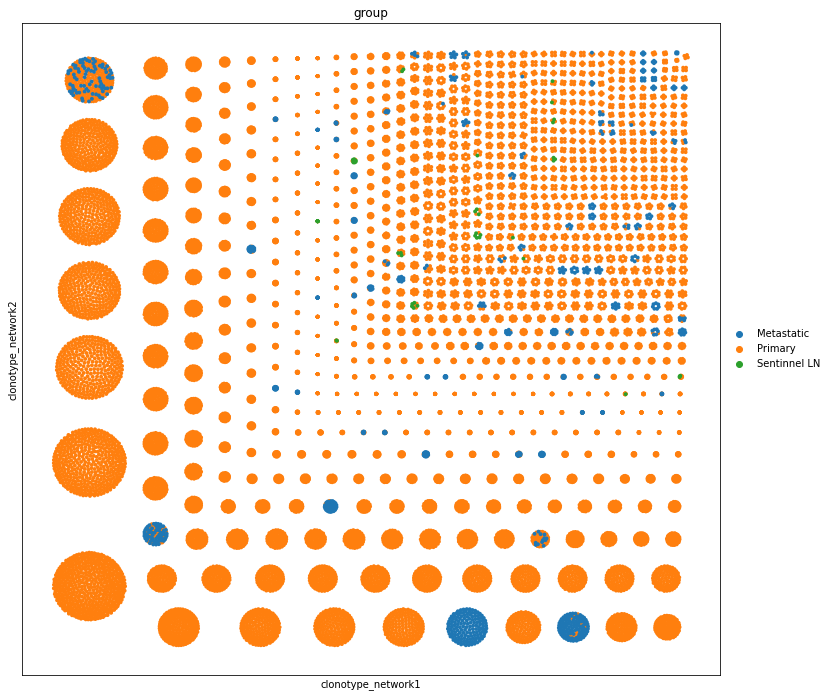

In [9]:
ir.pl.clonotype_network(combined, color="group", size=60, panel_size=(12, 12))
plt.show()

#### It is not surprised to see that primary and metastatic tumor tissues provide common clonotypes, but it is very interesting that 295 and 314 actually have a lot in common in their clonotypes.

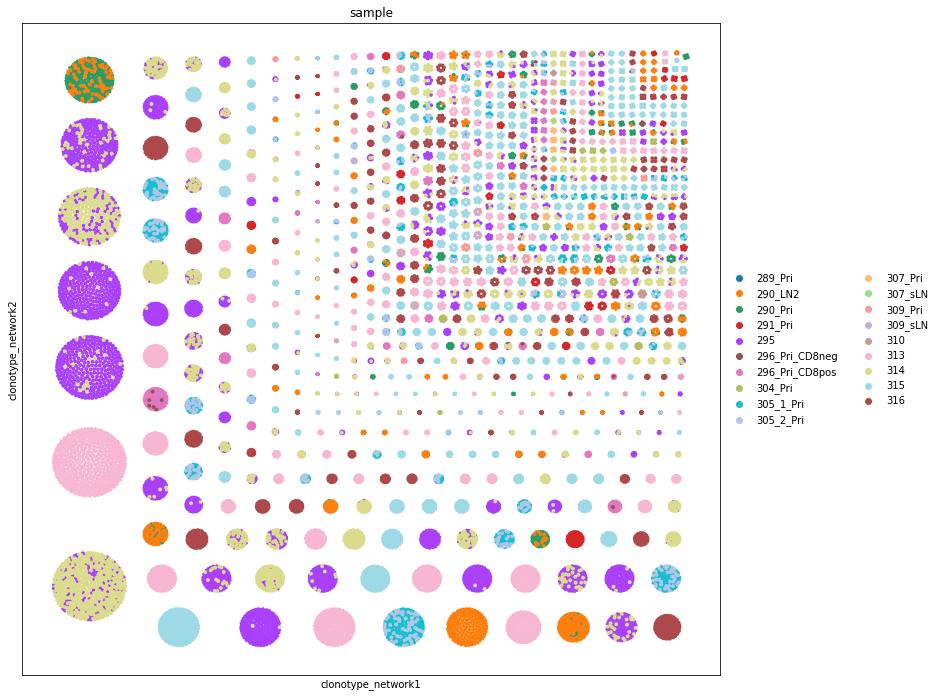

In [10]:
ir.pl.clonotype_network(combined, color="sample", size=60, panel_size=(12, 12))
plt.show()

# Clonotype Expansion

In [11]:
ir.tl.clonal_expansion(combined,clip_at=5)

#### Most of the expanded clonotypes belong to the primary tumor group

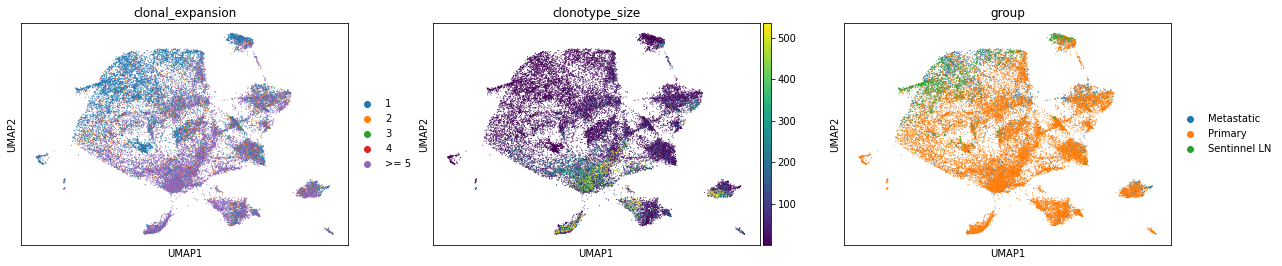

In [12]:
sc.pl.umap(combined, color=['clonal_expansion','clonotype_size','group'])

#### The ratio of clonally expanded T-cells is also higher in primary tumor group

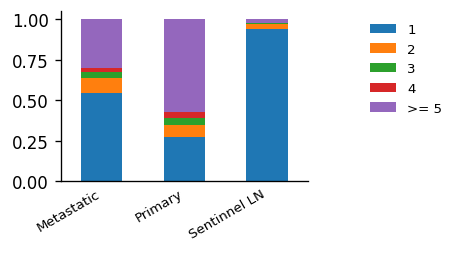

In [13]:
ir.pl.clonal_expansion(combined, groupby='group', clip_at=5)
plt.show()

#### Batch-wise, the ratio of clonally expanded T-cells are not drastically different which is a good signal.

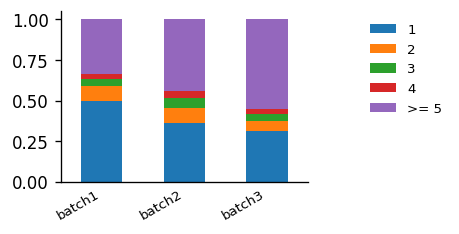

In [14]:
ir.pl.clonal_expansion(combined, groupby='bat', clip_at=5)
plt.show()

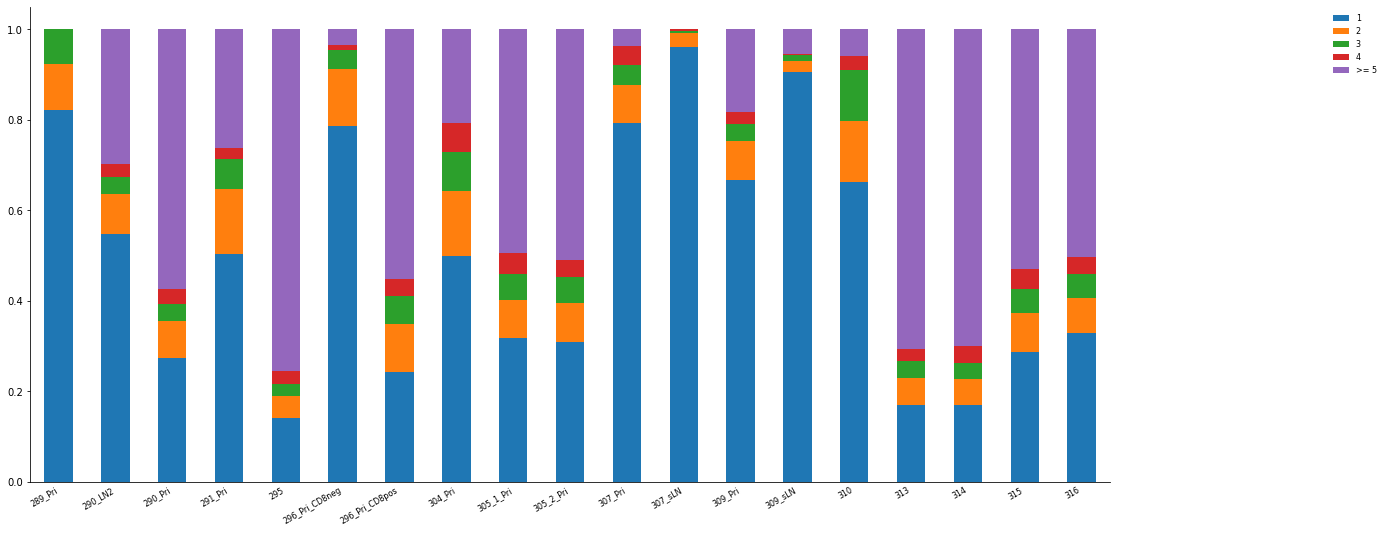

In [15]:
fig, ax = plt.subplots(figsize=(25, 12))
ir.pl.clonal_expansion(combined, groupby='sample', clip_at=5,ax=ax)
plt.show()

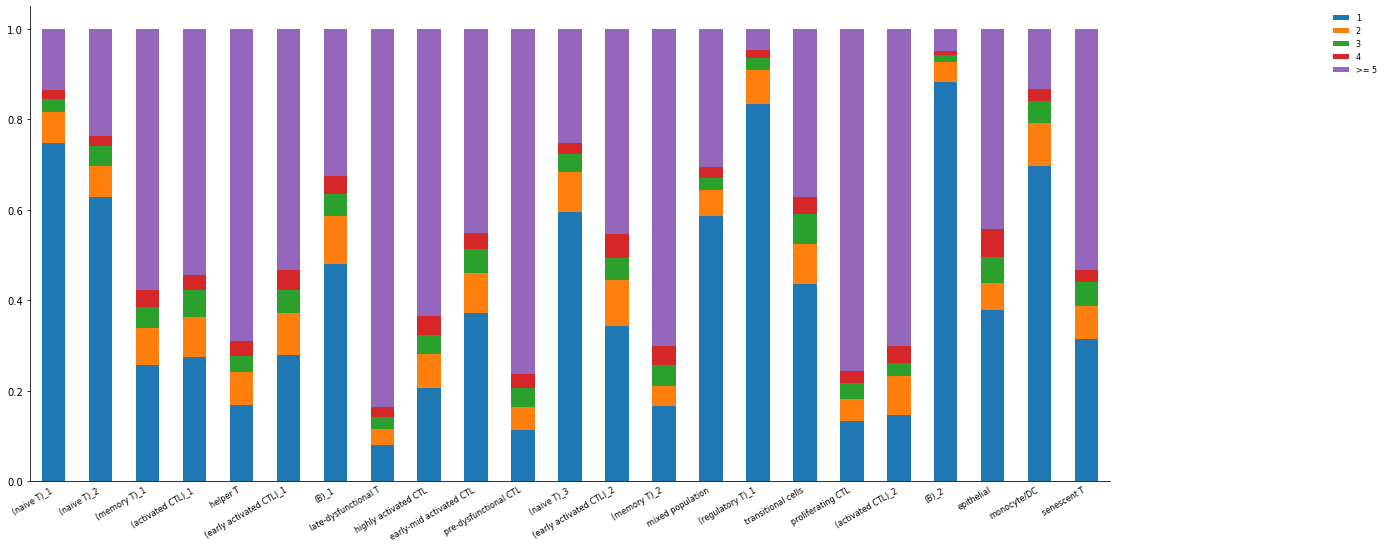

In [16]:
fig, ax = plt.subplots(figsize=(25, 12))
ir.pl.clonal_expansion(combined, groupby='leiden', clip_at=5,ax=ax)
plt.show()

#### Clonotype frequency of primary tumor completely takes over 

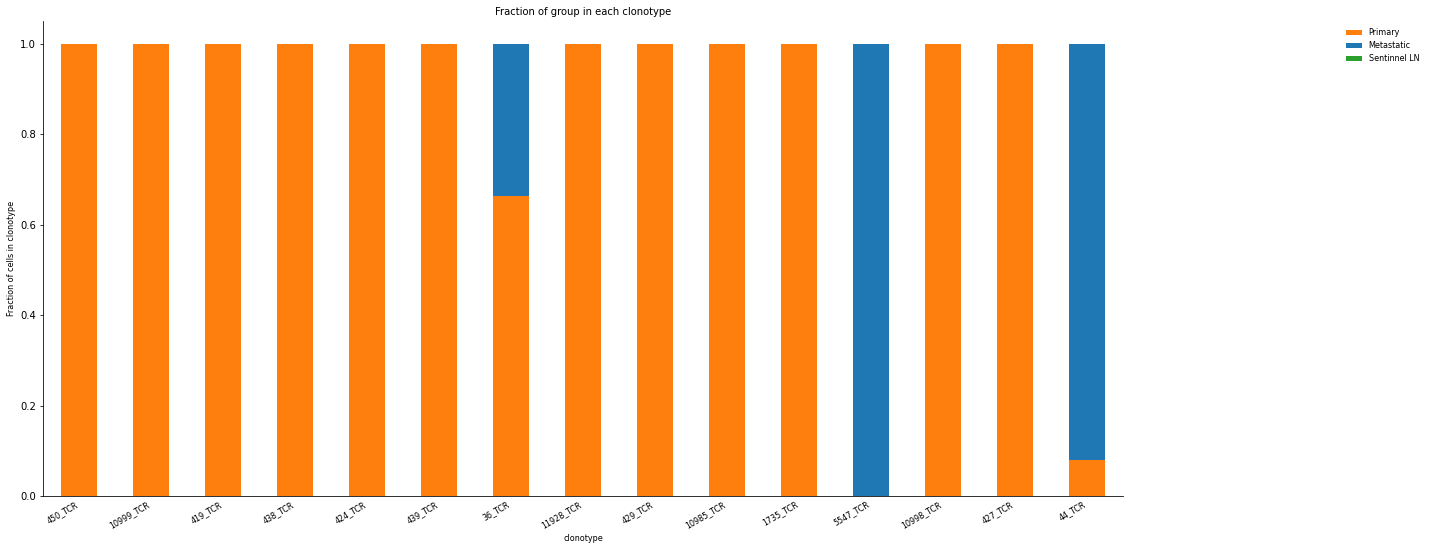

In [17]:
fig, ax = plt.subplots(figsize=(25, 12))
ax = ir.pl.group_abundance(combined, groupby="clonotype", target_col="group", sort='count',max_cols=15,
                           normalize='clonotype', fig_kws={"dpi": 100},ax=ax)
plt.show()

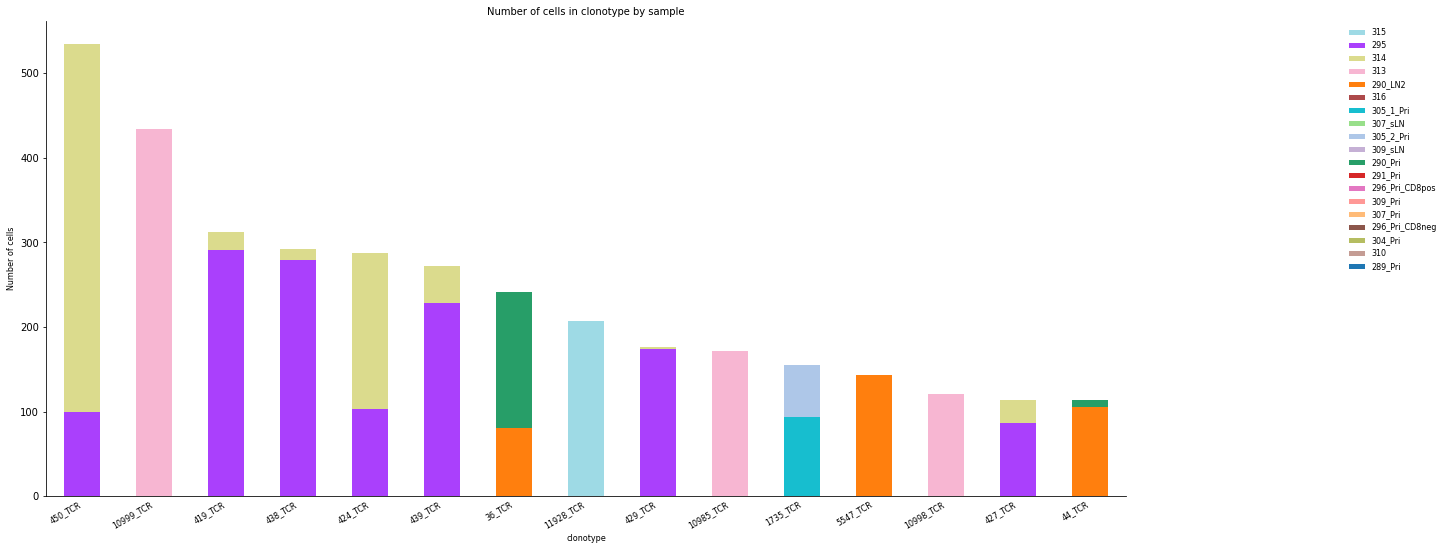

In [18]:
fig, ax = plt.subplots(figsize=(25, 12))
ir.pl.group_abundance(combined, groupby="clonotype", target_col="sample",max_cols=15,ax=ax)
plt.show()

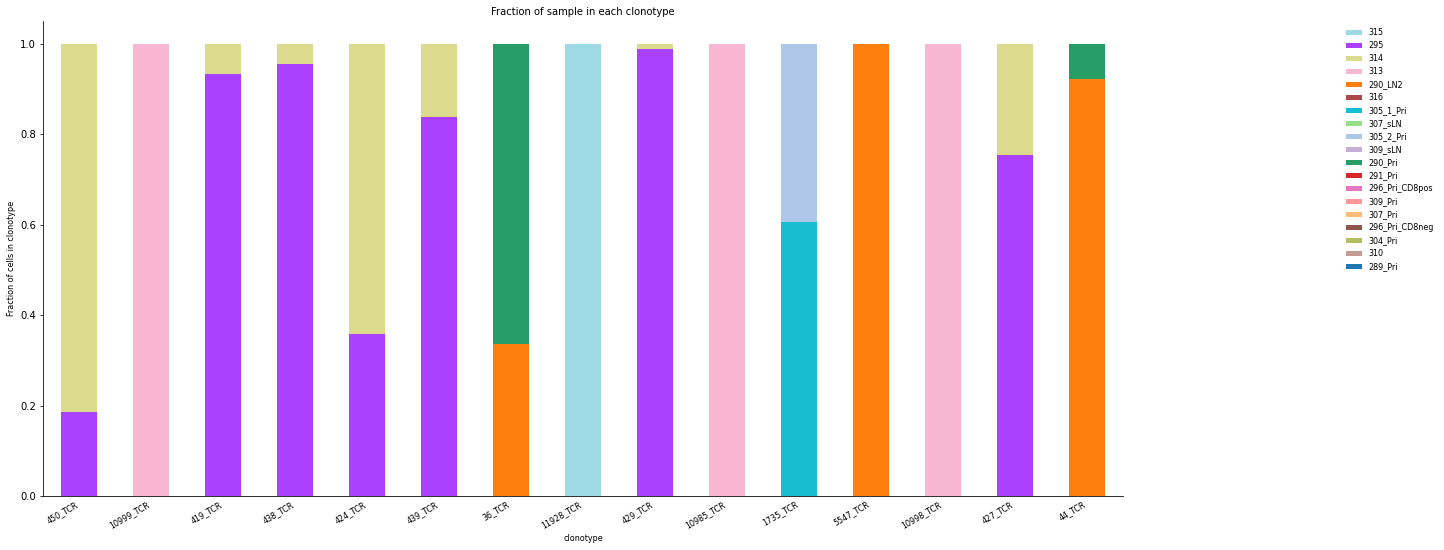

In [19]:
fig, ax = plt.subplots(figsize=(25, 12))
ir.pl.group_abundance(combined, groupby='clonotype', normalize='clonotype',target_col='sample',max_cols=15,ax=ax)
plt.show()

# Repertoire Simiarity

In [20]:
df, dst, lk = ir.tl.repertoire_overlap(combined, 'sample', inplace=False)

#### Primary and metastatic samples of the same patient are more closely related which is understandable. What's interesting in this plot is the high similarity between sample 295 and 314. This can also be seen from the clonotype network plot which shows that 295 and 314 do share a lot of common clonotypes.

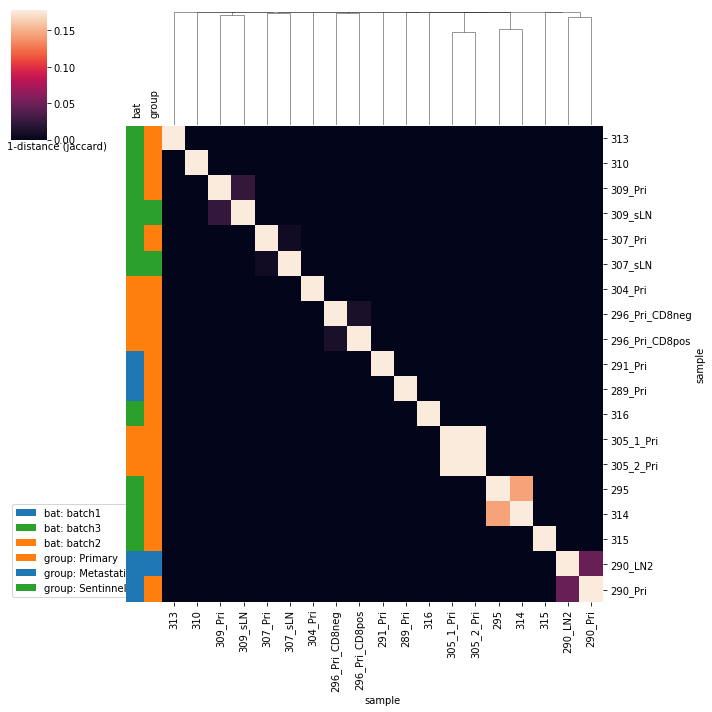

In [21]:
ir.pl.repertoire_overlap(combined, 'sample', heatmap_cats=['bat', 'group'])
plt.show()

## Clonal Diversity

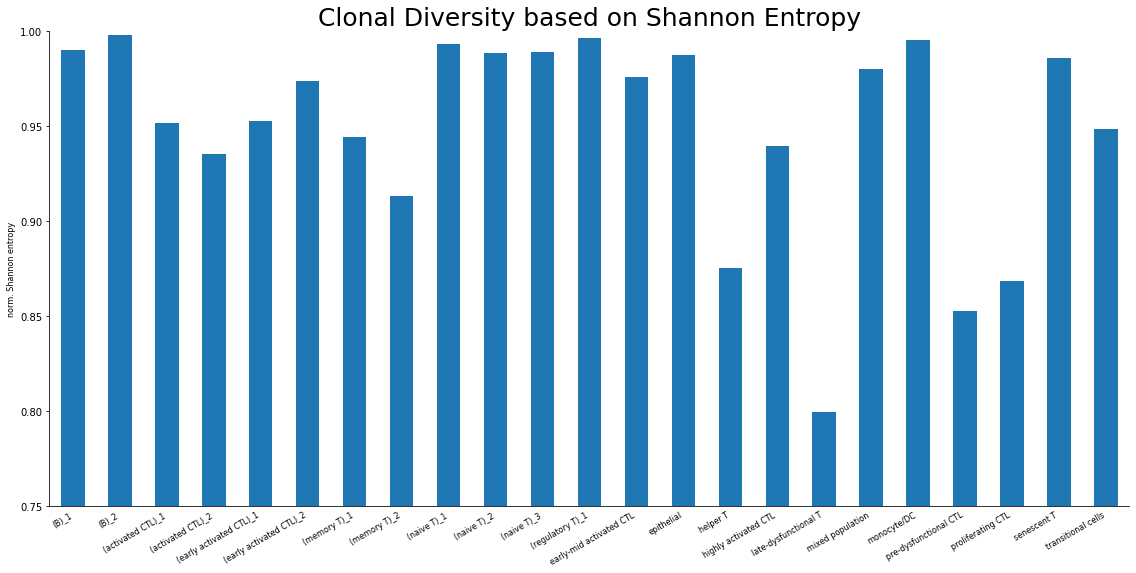

In [22]:
fig, ax = plt.subplots(figsize=(25,12))
ir.pl.alpha_diversity(combined, groupby='leiden', target_col='clonotype', vistype='bar',ax=ax)
ax.set_title('Clonal Diversity based on Shannon Entropy',fontsize=25)
ax.get_legend().remove()
plt.show()

## Top 5 Clones

In [23]:
# the number of top clonotypes we are interested in
n = 15
# extract the clonotype indeces of the top clonotypes
top_n_clonotypes = list(combined.obs['clonotype'].value_counts().index[:n])
# an argument to put in for the 'groups=' in sc.pl.umap, which would be the name label for the clonotypes in the umap plot
group_arg = ['top_'+str(i+1)+'_clonotype' for i in range(n)]

In [24]:
# store the top_n_clonotype assignments for each cell
cell_top_clonotypes = []

for cell in combined.obs.index:
    try:
        cell_top_clonotypes.append('top_'+str(top_n_clonotypes.index(combined.obs.loc[cell]['clonotype'])+1)+'_clonotype')
    except:
        cell_top_clonotypes.append('others')
        
# create new column to store top_n_clonotypes
combined.obs['top_n_clonotypes']=cell_top_clonotypes

In [25]:
top_clonotype_cell_coor = {}
for i in range(n):
    coor_x = [coor[0] for coor in combined[combined.obs['top_n_clonotypes']=='top_'+str(i+1)+'_clonotype'].obsm['X_umap']]
    coor_y = [coor[1] for coor in combined[combined.obs['top_n_clonotypes']=='top_'+str(i+1)+'_clonotype'].obsm['X_umap']]
    top_clonotype_cell_coor['top_'+str(i+1)+'_clonotype'] = [coor_x, coor_y]

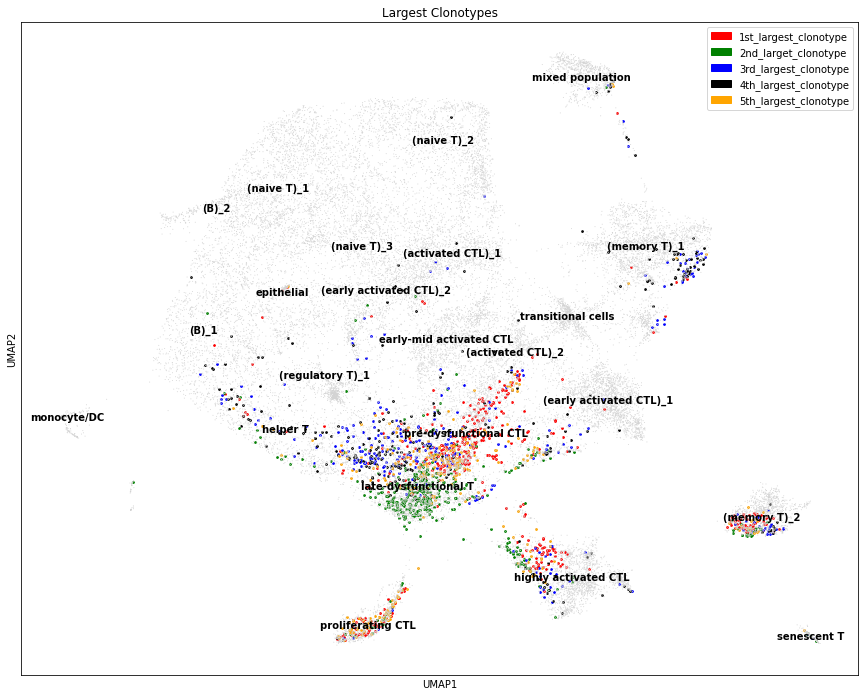

In [33]:
# legend_colors
color = ['red','green','blue','black','orange','purple','cyan','pink','brown','olive','yellow','khaki','lightgreen','crimson',
         'teal']
# texts to put for the legend
texts = ['1st_largest_clonotype','2nd_larget_clonotype','3rd_largest_clonotype']+[str(i+1)+'th_largest_clonotype' for i in range(3,n)]
# customized patch shown in legend instead of just a dot which is barely seeable
patches = [ mpatches.Patch(color=color[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]

fig, ax = plt.subplots(figsize=(15,12))
## obtain UMAP coordinates for all cells (obsolete since we will use sc.pl.umap to also superimpose cluster annotation)
all_cells_umap_x = list(coor[0] for coor in combined.obsm['X_umap'])
all_cells_umap_y = list(coor[1] for coor in combined.obsm['X_umap'])
#ax.scatter(all_cells_umap_x,all_cells_umap_y,0.01,color='grey')

# the number of top clones to plot out
top_n_to_plot = 5
for i in range(top_n_to_plot):
    ax.scatter(top_clonotype_cell_coor['top_'+str(i+1)+'_clonotype'][0],
               top_clonotype_cell_coor['top_'+str(i+1)+'_clonotype'][1],3,color=color[i],
               label=str(i)+'_biggest__clonotype')
plt.legend(handles = patches[:top_n_to_plot]) # use the customized patch legends
sc.pl.umap(combined,color=['leiden'],legend_loc='on data',palette=['lightgrey'],ax=ax,title='Largest Clonotypes')
plt.show()

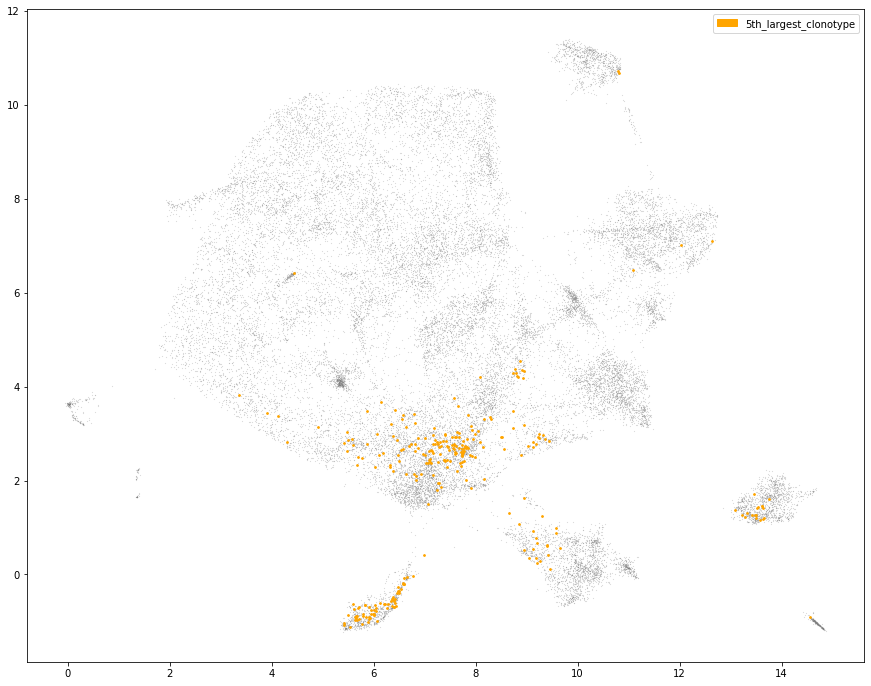

In [29]:
# i = 0,1,...,n-1 the top n clonotypes of interest
i = 4
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(all_cells_umap_x, all_cells_umap_y,0.01,color='grey')
ax.scatter(top_clonotype_cell_coor['top_'+str(i+1)+'_clonotype'][0],
           top_clonotype_cell_coor['top_'+str(i+1)+'_clonotype'][1],3,color=color[i],
           label=str(i)+'_biggest__clonotype')
plt.legend(handles=[patches[i]])
plt.show()

# Host sample for each top clonotype

In [34]:
for i, clonotype in enumerate(top_n_clonotypes):
    if (i+1)%10 == 1 and (i+1)//10!=1:
        print('The {}st largest clonotype comes from sample {}'.format(i+1, set(combined[combined.obs['clonotype']==clonotype].obs['sample'])))
    elif (i+1)%10 == 2 and (i+1)//10!=1:
        print('The {}nd largest clonotype comes from sample {}'.format(i+1, set(combined[combined.obs['clonotype']==clonotype].obs['sample'])))
    elif (i+1)%10 == 3 and (i+1)//10!=1:
        print('The {}rd largest clonotype comes from sample {}'.format(i+1, set(combined[combined.obs['clonotype']==clonotype].obs['sample'])))
    else:
        print('The {}th largest clonotype comes from sample {}'.format(i+1, set(combined[combined.obs['clonotype']==clonotype].obs['sample'])))

The 1st largest clonotype comes from sample {'295', '314'}
The 2nd largest clonotype comes from sample {'313'}
The 3rd largest clonotype comes from sample {'295', '314'}
The 4th largest clonotype comes from sample {'295', '314'}
The 5th largest clonotype comes from sample {'295', '314'}
The 6th largest clonotype comes from sample {'295', '314'}
The 7th largest clonotype comes from sample {'290_Pri', '290_LN2'}
The 8th largest clonotype comes from sample {'315'}
The 9th largest clonotype comes from sample {'295', '314'}
The 10th largest clonotype comes from sample {'313'}
The 11th largest clonotype comes from sample {'305_1_Pri', '305_2_Pri'}
The 12th largest clonotype comes from sample {'290_LN2'}
The 13th largest clonotype comes from sample {'313'}
The 14th largest clonotype comes from sample {'295', '314'}
The 15th largest clonotype comes from sample {'290_Pri', '290_LN2'}
